# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

We'll start by implementing the basic Constant Proportion Portfolio Insurance dynamic risk budgeting algorithm, and test it against different portfolios.

Let's begin, as usual, by loading up our `edhec_risk_kit` module.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit_119 as erk

# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The CPPI algorithm is surprisingly simple to implement. This takes as input, the returns of a risky asset and a safe asset, along with the initial wealth to invest at the start, along with a floor that should not be violated.

In [28]:
import pandas as pd
import numpy as np

risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

Now, we need to backtest this strategy by starting at the beginning and at every point in time:

1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier)
3. Compute the new asset value

Although we rarely use for-loops in working with time-series, relying instead of Pandas and Numpy to do the looping internally (and efficiently) this is easier to do with a traditional for-loop.

### An Aside on Efficiency

Although For-Loops are common, we've almost never used them so far. That is not an accident. For-Loops in python are expensive, and we have so far relied on numpy to do the looping for us efficiently in C. The problem is that it's easy to miss the fact that there is a loop here.

For instance, consider two implementations of the function to compound returns.


In [10]:
def compound1(r):
    return np.expm1(np.log1p(r).sum())

def compound2(r):
    return (r+1).prod()-1

compound1(ind_return[["Steel", "Fin", "Beer"]])

Steel      435.580153
Fin       5778.433650
Beer     35820.527452
dtype: float64

In [11]:
compound2(ind_return[["Steel", "Fin", "Beer"]])

Steel      435.580153
Fin       5778.433650
Beer     35820.527452
dtype: float64

They both produce the same result, but are they identical? The second one might appear a bit more clear to some programmers, which of these is more efficient? We can find out by using the `%timeit` magic.

In [12]:
%timeit compound1(ind_return)

779 µs ± 139 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit compound2(ind_return)

626 µs ± 178 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Astonishingly, on my computer, `compound1` took around 0.8 millisecond, while `compound2` took more than 8 ms per loop, which is an entire order of magnitude! Let's add this to our toolkit, which we'll use later:

```python
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())
```

And now, back to CPPI ...

In [22]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)


In [37]:
account_value =start
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    # print(cushion_history)

account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


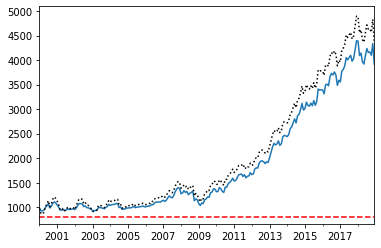

In [24]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

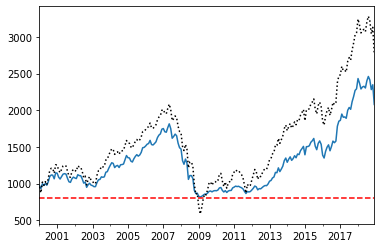

In [25]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

<AxesSubplot:>

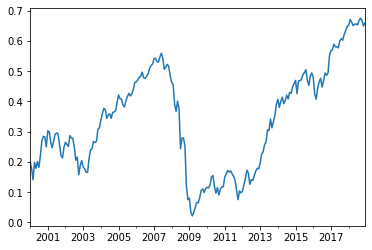

In [26]:
cushion_history["Fin"].plot()

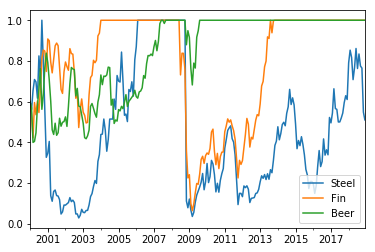

In [12]:
risky_w_history.plot()

Let's put this all into a new function which we can add to our `edhec_risk_kit.py`:

```python
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result

```


And while we're at it, let's also write a convenience function to provide summary statistics on a set of returns:

```python

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

```


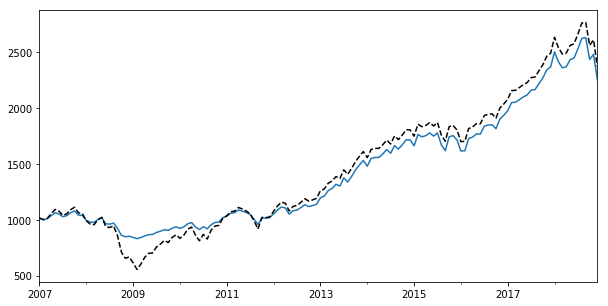

In [13]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

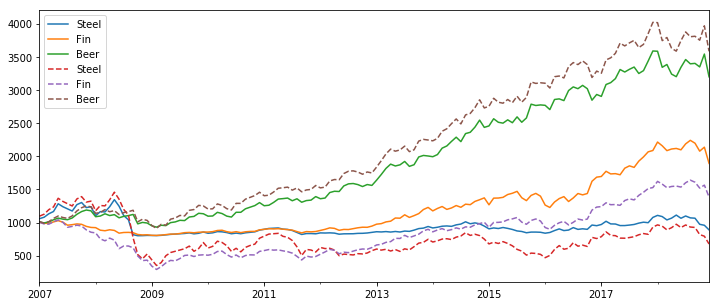

In [14]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [15]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.004543,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.000311,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.001146,0.608531,-0.217280


In [16]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.009735,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,-0.000156,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,-0.000083,0.620132,-0.271368


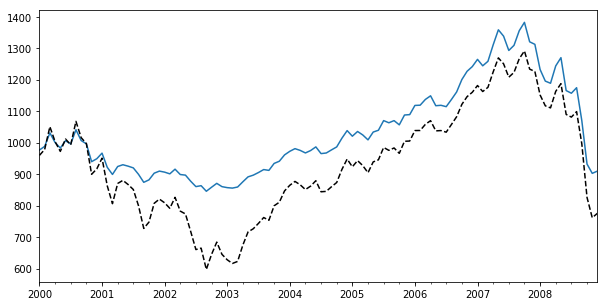

In [17]:
btr = erk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

## Explicitly Limiting Drawdowns

Modify the code to adjust the floor if needed, based on an additional new parameter `drawdown`.

```python
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
```

You can now call `run_cppi` witk a parameter `drawdown`. For instance, to run CPPI and limit the drawdown to 25%

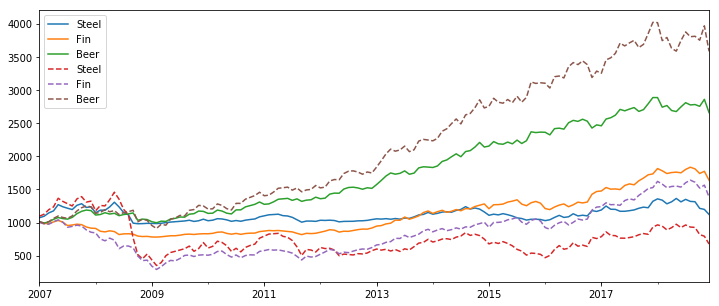

In [18]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [19]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


In [20]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.718465
Beer,0.111554,0.127971,0.620132,-0.271368


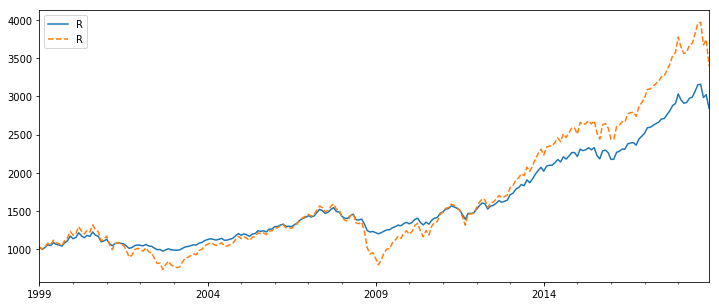

In [21]:
btr = erk.run_cppi(tmi_return["1999":], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [22]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.052391,0.078951,0.275935,-0.220824


In [23]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.06137,0.148571,0.205314,-0.499943
